In [181]:
# import relevant packages
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from eofs.standard import Eof
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Load in the datasets 
sst = xr.open_dataset('sst_monthly.nc')['sst']
msl = xr.open_dataset('msl_monthly.nc')['msl']
u10 = xr.open_dataset('u10_monthly.nc')['u10']
v10 = xr.open_dataset('v10_monthly.nc')['v10']

In [182]:
# relevant global variables
# Define bi-monthly season labels
bi_monthly_labels = [
    "Dec-Jan", "Jan-Feb", "Feb-Mar", "Mar-Apr", "Apr-May", "May-Jun",
    "Jun-Jul", "Jul-Aug", "Aug-Sep", "Sep-Oct", "Oct-Nov", "Nov-Dec"
]

In [183]:
# slice data for the specified region, 30S–30N, 100E–70W
region = dict(latitude=slice(30, -30), longitude=slice(100, 290)) # 70W == 360-70=290 degrees

# reduce datasets to information for the specified region only
sst_red = sst.sel(**region)
msl_red = msl.sel(**region)
u10_red = u10.sel(**region)
v10_red = v10.sel(**region)

In [184]:
# flatten spatial dimensions for all variables, include rolling bi-monthly condensation
msl_flat = msl_red.stack(space=('latitude', 'longitude'))
u10_flat = u10_red.stack(space=('latitude', 'longitude'))
v10_flat = v10_red.stack(space=('latitude', 'longitude'))
sst_flat = sst_red.stack(space=('latitude', 'longitude'))

# identify sea coordinates (non-NaN points in SST) across all time steps
valid_points = ~sst_flat.isnull().any(dim='time')

# reduce ALL datasets to sea-only points
sst_sea = sst_flat[:, valid_points]
msl_sea = msl_flat[:, valid_points]
u10_sea = u10_flat[:, valid_points]
v10_sea = v10_flat[:, valid_points]

### doing the bi-monthly seasons

In [185]:
def groupData(data):
    ds = data.rolling(time=2, center=True).mean().dropna('time')

    # Create a bi-monthly index for each time point
    def assign_bimonthly_group(time):

        month = time.values
        if month == 12:  # December -> "Dec-Jan"
            return "Dec-Jan"
        else:
            return bi_monthly_labels[month]

    # Assign bi-monthly groups as a new coordinate
    ds = ds.assign_coords(bimonthly_season=("time", [assign_bimonthly_group(t) for t in ds["time"].dt.month]))

    # Group data by the bimonthly season
    grouped = ds.groupby("bimonthly_season")

    # Example: Compute the mean for each bimonthly season
    bimonthly_means = grouped.mean(dim="time")
    return grouped


In [186]:
# group each dataset into the bimonthly seasons

sst_grouped = groupData(sst_sea)
msl_grouped = groupData(msl_sea)
u10_grouped = groupData(u10_sea)
v10_grouped = groupData(v10_sea)

In [187]:
# normalise each dataset - i.e. obtain anomaly matrices
# procedure: subtract the mean and divide by the standard deviation
def normalize(data):
    mean = data.mean(dim='time', skipna=True)
    std = data.std(dim='time', skipna=True)
    return (data - mean) / std

sst_normalised = normalize(sst_grouped)
msl_normalised = normalize(msl_grouped)
u10_normalised = normalize(u10_grouped)
v10_normalised = normalize(v10_grouped)

In [188]:
# Concatenate normalised datasets into a single matrix **for each bi-monthly season!
DJ = []
JF = []
FM = []
MA = []
AM = []
MJ = []
JJ = []
JA = []
AS = []
SO = []
ON = []
ND = []

datasets = [sst_normalised, msl_normalised, u10_normalised, v10_normalised]
for i in range(4):
    ds = datasets[i]
    DJ.append(ds.sel(bimonthly_season = 'Dec-Jan'))
    JF.append(ds.sel(bimonthly_season = 'Jan-Feb'))
    FM.append(ds.sel(bimonthly_season = 'Feb-Mar'))
    MA.append(ds.sel(bimonthly_season = 'Mar-Apr'))
    AM.append(ds.sel(bimonthly_season ='Apr-May'))
    MJ.append(ds.sel(bimonthly_season = 'May-Jun'))
    JJ.append(ds.sel(bimonthly_season = 'Jun-Jul'))
    JA.append(ds.sel(bimonthly_season = 'Jul-Aug'))
    AS.append(ds.sel(bimonthly_season = 'Aug-Sep'))
    SO.append(ds.sel(bimonthly_season = 'Sep-Oct'))
    ON.append(ds.sel(bimonthly_season = 'Oct-Nov'))
    ND.append(ds.sel(bimonthly_season = 'Nov-Dec'))

In [189]:
# concatenating along the SPATIAL DIMENSION
DJ_comb = xr.concat(DJ, dim='space')
JF_comb = xr.concat(JF, dim='space')
FM_comb = xr.concat(FM, dim='space')
MA_comb = xr.concat(MA, dim='space')
AM_comb = xr.concat(AM, dim='space')
MJ_comb = xr.concat(MJ, dim='space')
JJ_comb = xr.concat(JJ, dim='space')
JA_comb = xr.concat(JA, dim='space')
AS_comb = xr.concat(AS, dim='space')
SO_comb = xr.concat(SO, dim='space')
ON_comb = xr.concat(ON, dim='space')
ND_comb = xr.concat(ND, dim='space')


In [190]:
all_data = [DJ_comb, JF_comb, FM_comb, MA_comb, AM_comb, MJ_comb, JJ_comb, JA_comb, AS_comb, SO_comb, ON_comb, ND_comb]

In [191]:
# Takes < 1.5min for all the seasons
def getEofs():
    eofs = []
    pcs = []
    for i in range(12):
        print(f"Working on the {i}th season...")
        data_matrix = all_data[i].fillna(0).values
        solver = Eof(data_matrix)
        eofs.append(solver.eofs(neofs=1))
        pcs.append(solver.pcs(npcs=1))
    return eofs, pcs
eofs, pcs = getEofs()

Working on the 0th dataset...
Working on the 1th dataset...
Working on the 2th dataset...
Working on the 3th dataset...
Working on the 4th dataset...
Working on the 5th dataset...
Working on the 6th dataset...
Working on the 7th dataset...
Working on the 8th dataset...
Working on the 9th dataset...
Working on the 10th dataset...
Working on the 11th dataset...


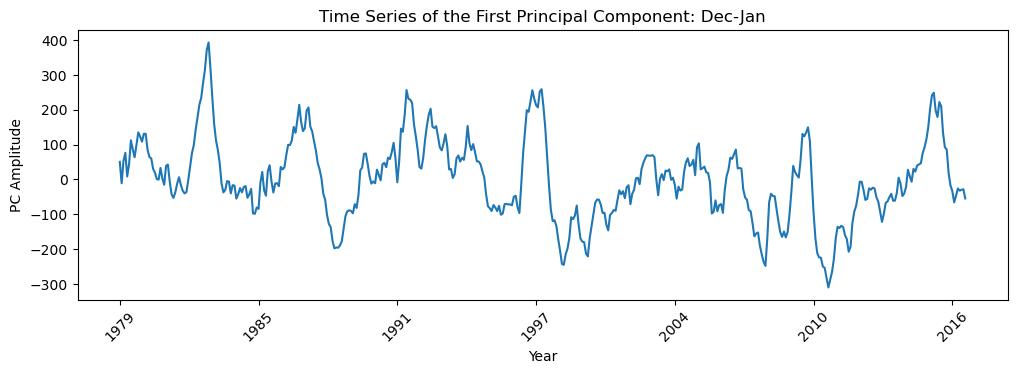

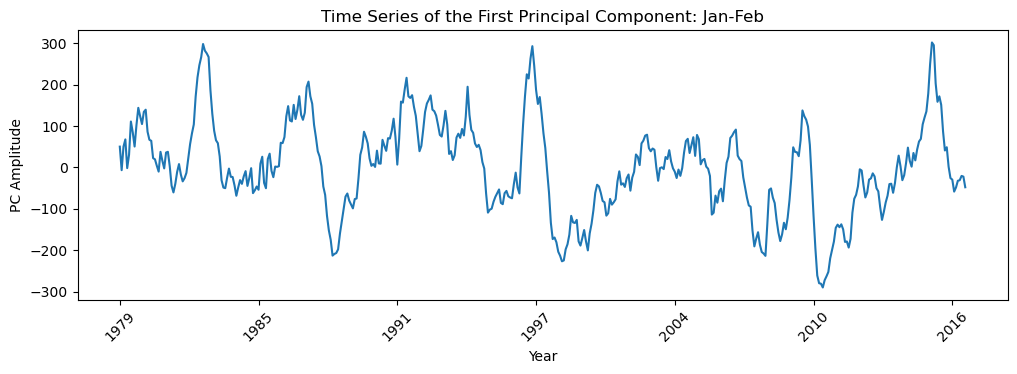

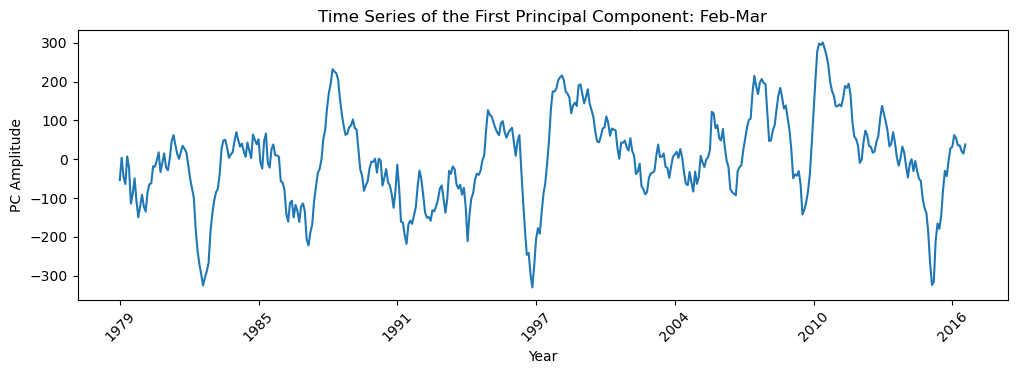

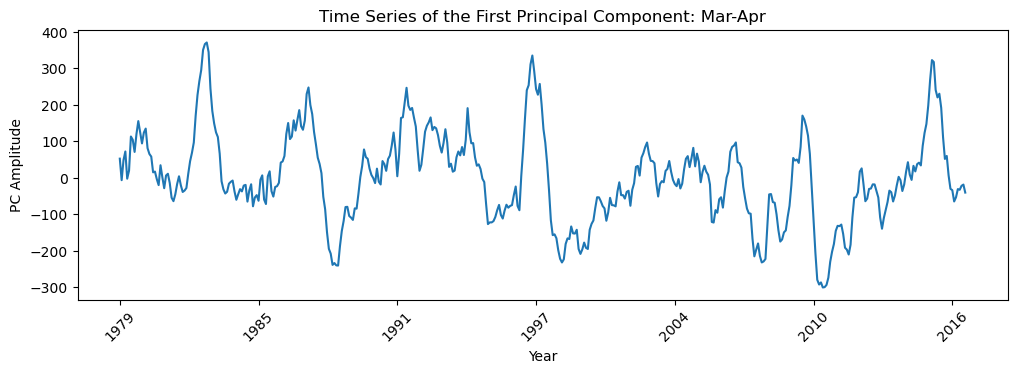

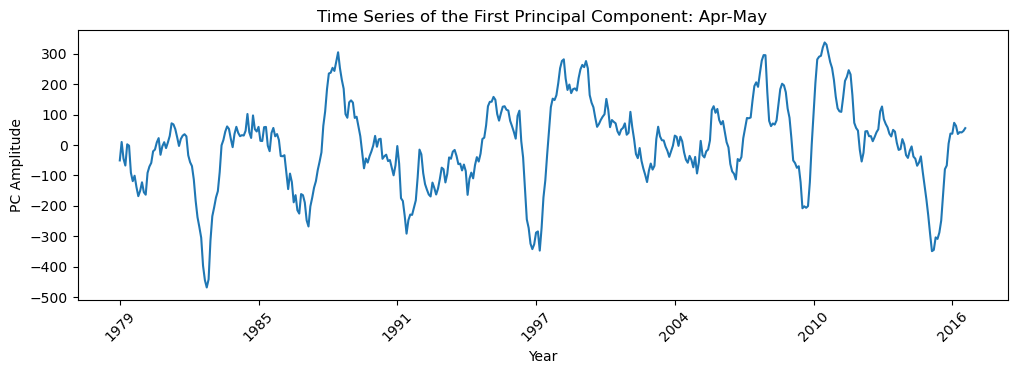

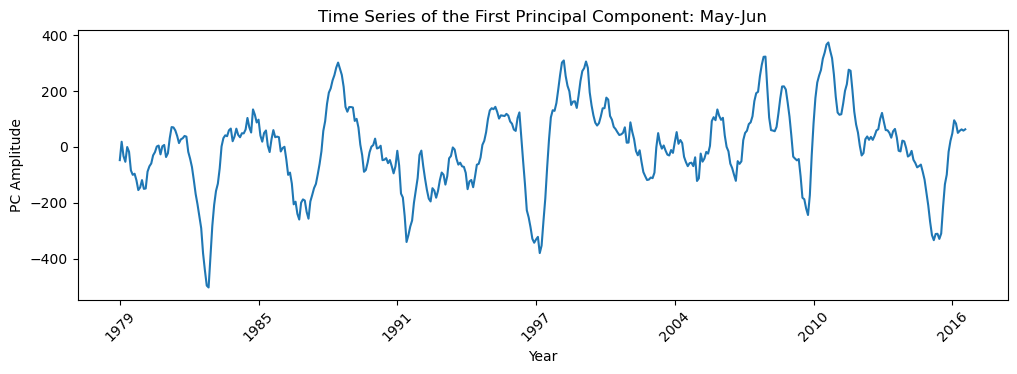

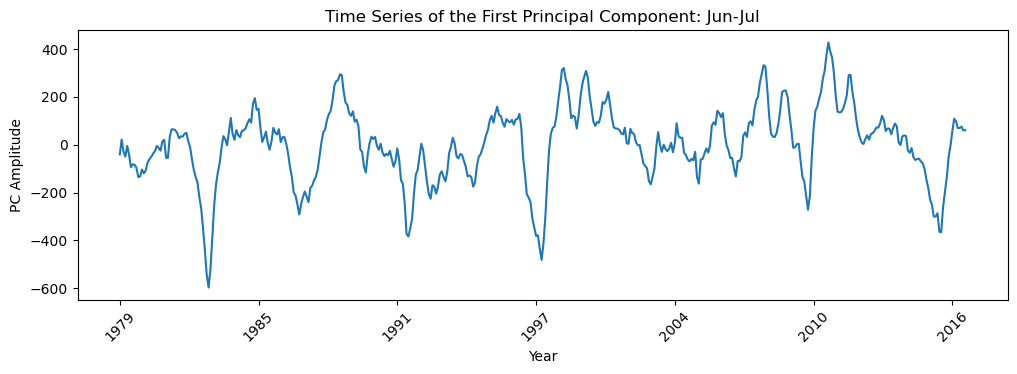

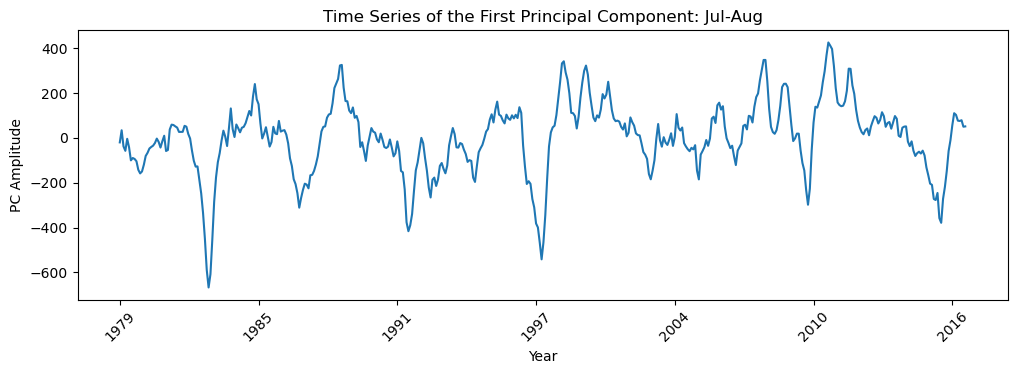

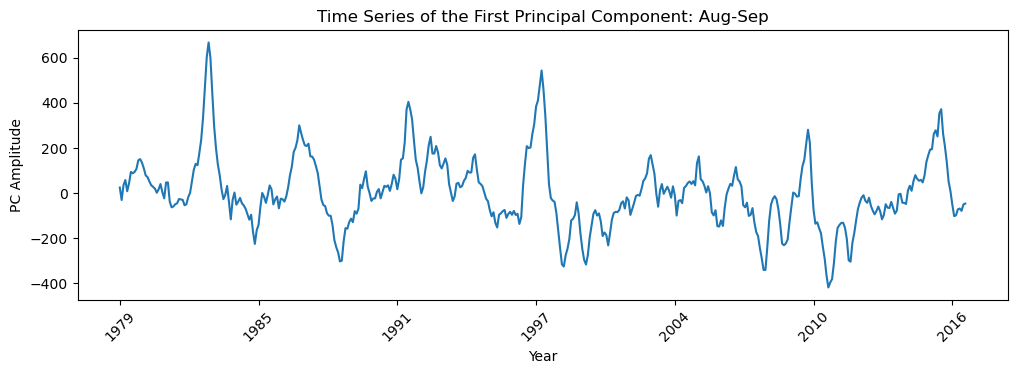

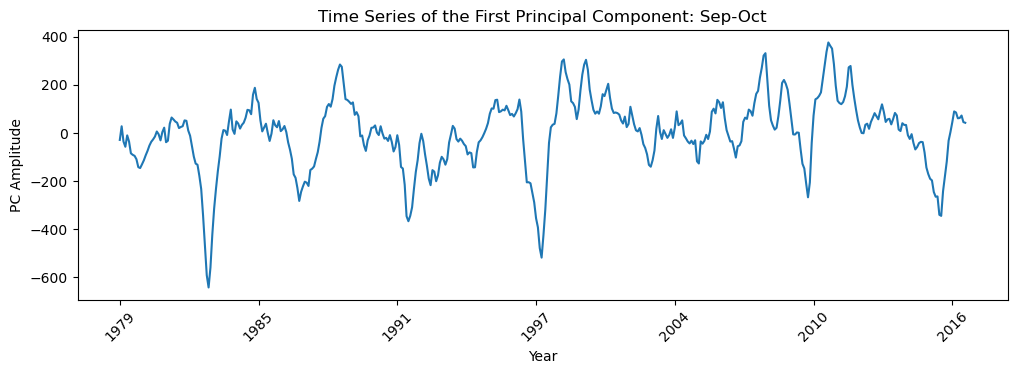

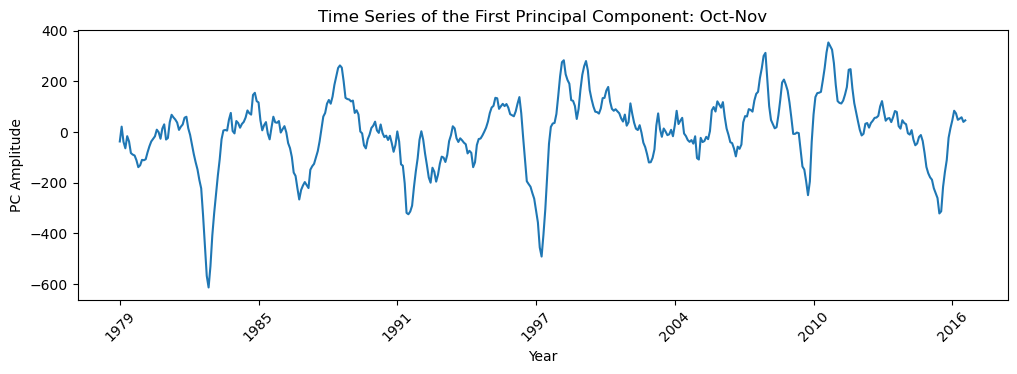

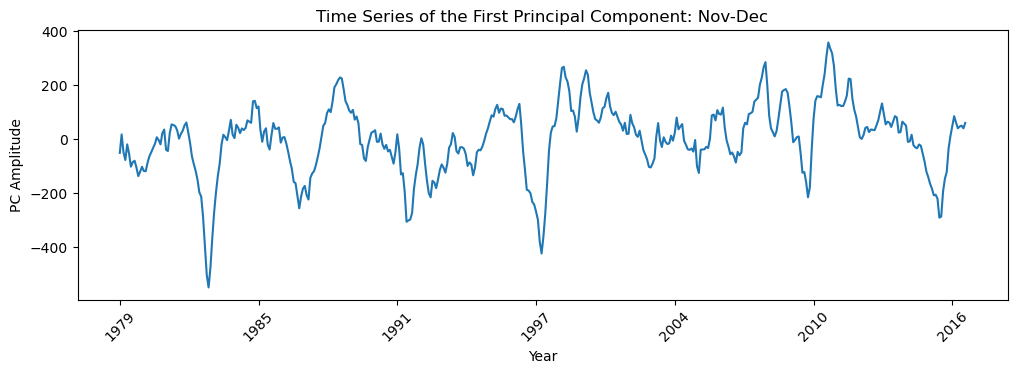

In [192]:
# INPUT:
# pcs = pcs timeseries to plot
def plotTimeSeries(pcs):
    # saving indices and years every 75 years (just to make the plot less cluttered on the x axis)
    indices =[]
    years = []
    xvals = sst.time.to_numpy()
    for i, year in enumerate(xvals):
        if i%75 == 0:
            indices.append(i)
            years.append(year.astype('datetime64[Y]').astype(int) + 1970)
    
    # Plot the time series for each bi-monthly season
    for i in range(12):

        plt.figure(figsize = (12,3.5))
        plt.plot(pcs[i])
        plt.xticks(indices, years, rotation = 45)
        plt.title(f'Time Series of the First Principal Component: {bi_monthly_labels[i]}')
        plt.xlabel('Year')
        plt.ylabel('PC Amplitude')
        plt.show()

plotTimeSeries(pcs)

In [193]:
# storing coordinates of the whole grid
gridpoints = []
for i in range(len(msl_flat.space.values)):
    coord = msl_flat.space.values[i]
    gridpoints.append(np.array(coord).tolist())

seapoints = []
for i in range(len(sst_sea.space.values)):
    coord = sst_sea.space.values[i]
    seapoints.append(np.array(coord).tolist())

# find indices of sea points in the whole grid
# NB: not a very efficient way to do this, takes a while to run (~45s)
sea_inds = [np.where((np.array(gridpoints) == coord).all(axis=1))[0][0] for coord in seapoints]
land_inds = np.setdiff1d(np.arange(len(gridpoints)), sea_inds)

# physical grid points (for plotting)
lat = msl_red['latitude'].to_numpy()
lon = msl_red['longitude'].to_numpy()

In [194]:
# function to plot the loading patterns (contour maps) of the EOF analyses
# INPUT: loadings = eofs[0] output from the solver
def plot_loadingPatterns(loadings, month):

    # prepare figure
    fig, ax = plt.subplots(ncols = 2, nrows = 2, figsize = (15,8), 
                           subplot_kw={"projection": ccrs.PlateCarree()})
    ax=ax.ravel()

    # titles for the subplots
    names = ["Sea Surface Temperature",
             "Mean Sea Level Pressure",
             "10m Meridional Wind Speeds",
             "10m Zonal Wind Speeds "]

    # endpoints of the slices for plotting
    slices = [0, len(sst_normalised[1]), 
              len(msl_normalised[1]), 
              len(u10_normalised[1]), 
              len(v10_normalised[1])]
    start = slices[0]       # initialise slice locations
    end = slices[1]

    # blank canvas to place results onto
    canvas = np.zeros( (len(lat), len(lon)) )

    # convert 1D indices into 2D indices
    sea_rows, sea_cols = np.unravel_index(sea_inds, canvas.shape)
    land_rows, land_cols = np.unravel_index(land_inds, canvas.shape)

    # plot each of the loading patterns
    for i in range(4):

        # slice the block of (sea) data corresponding to this variable
        block = loadings[start:end]

        # place data onto the canvas
        canvas[sea_rows, sea_cols] = block                  # place sea data at sea coordinates
        canvas[land_rows, land_cols] = 0                    # place 0s at land coords

        # plot the loading pattern
        T = ax[i].contourf(lon, lat, canvas, cmap='coolwarm')
        ax[i].set_title(names[i])
        ax[i].set_xlabel('Longitude')
        ax[i].set_ylabel('Latitude')
        # ax[i].set_extent([lon.min(), lon.max(), lat.min(), lat.max()])
        ax[i].set_xlim(lon.min(), lon.max())  # Longitude bounds
        ax[i].set_ylim(lat.min(), lat.max())  # Latitude bounds
        ax[i].add_feature(cfeature.COASTLINE, linewidth=0.8)
        ax[i].add_feature(cfeature.LAND, facecolor="white")
        plt.colorbar(T, ax=ax[i])

        # update the start and end points for the next slice
        start = end
        if i < 3:
            end += slices[i+2] 

    plt.suptitle(f"First EOF Loading Patterns: {month}")
    plt.tight_layout()
    plt.show()

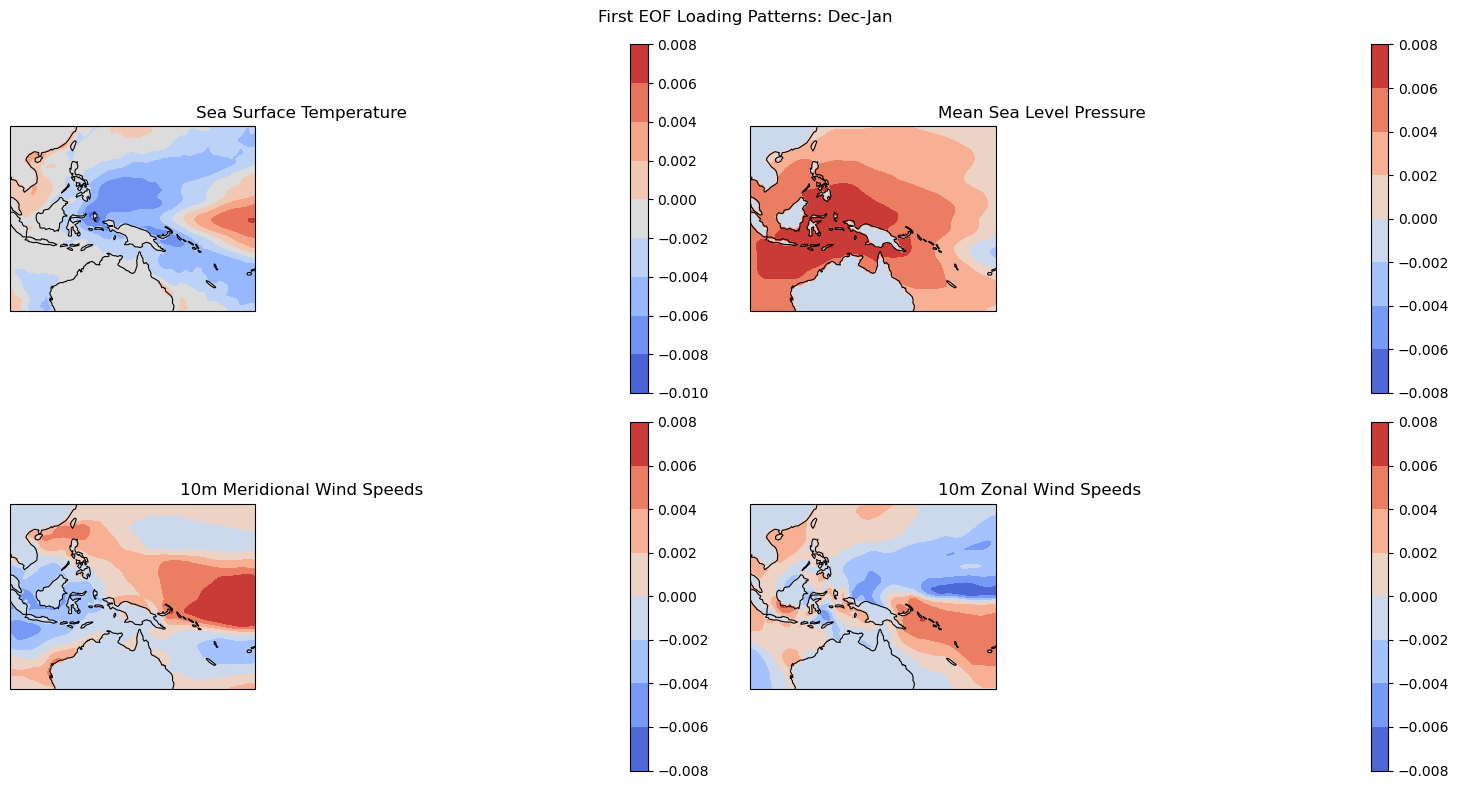

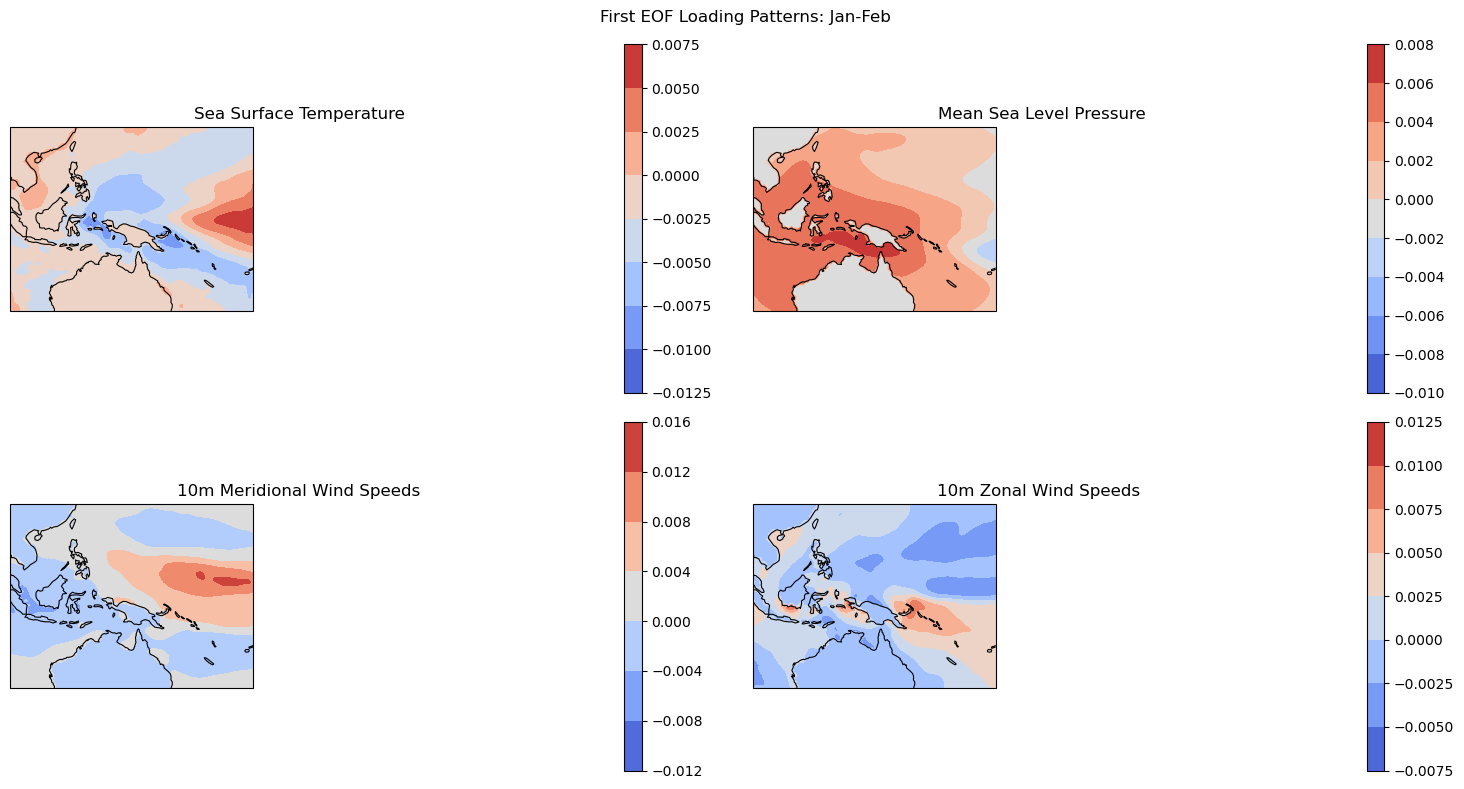

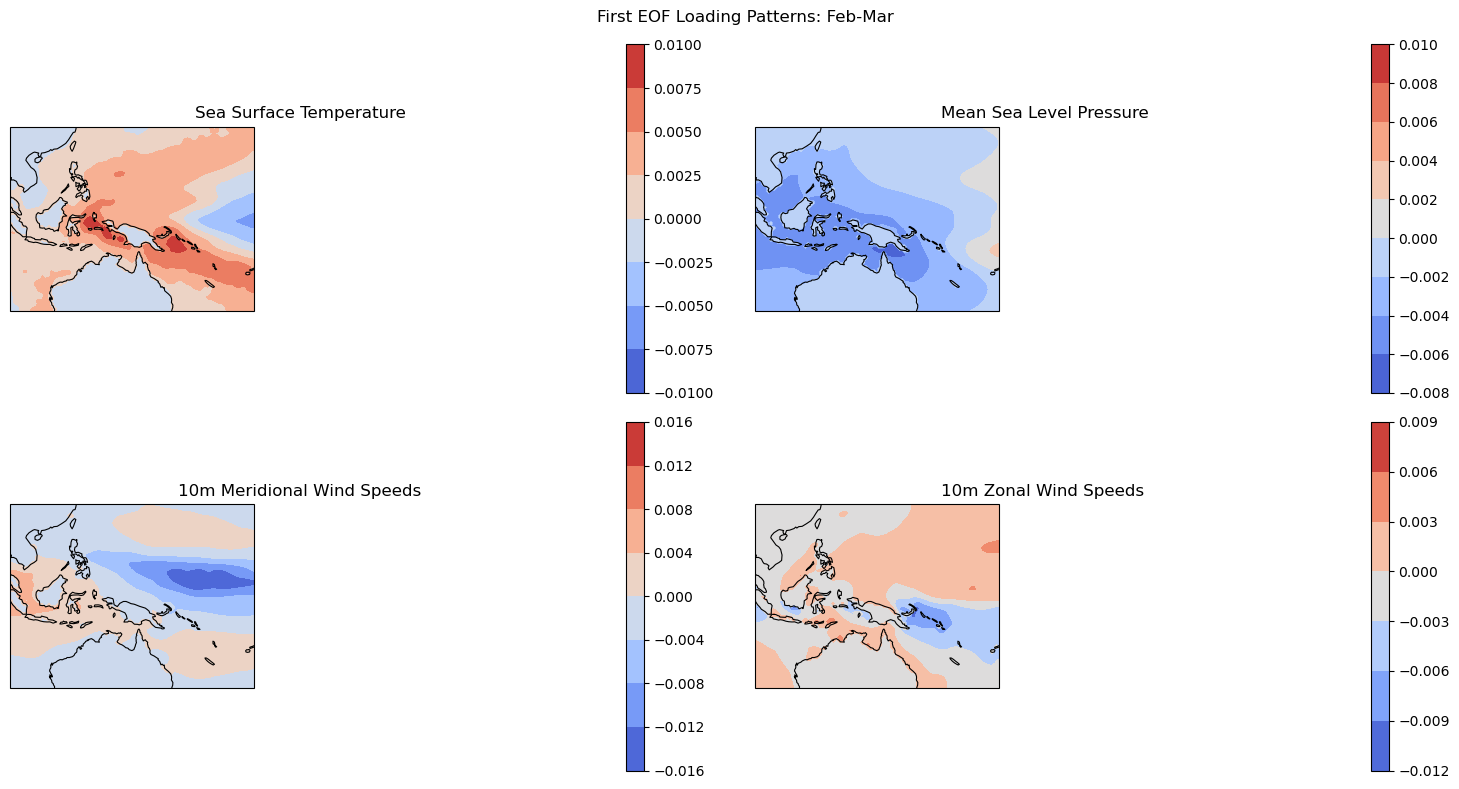

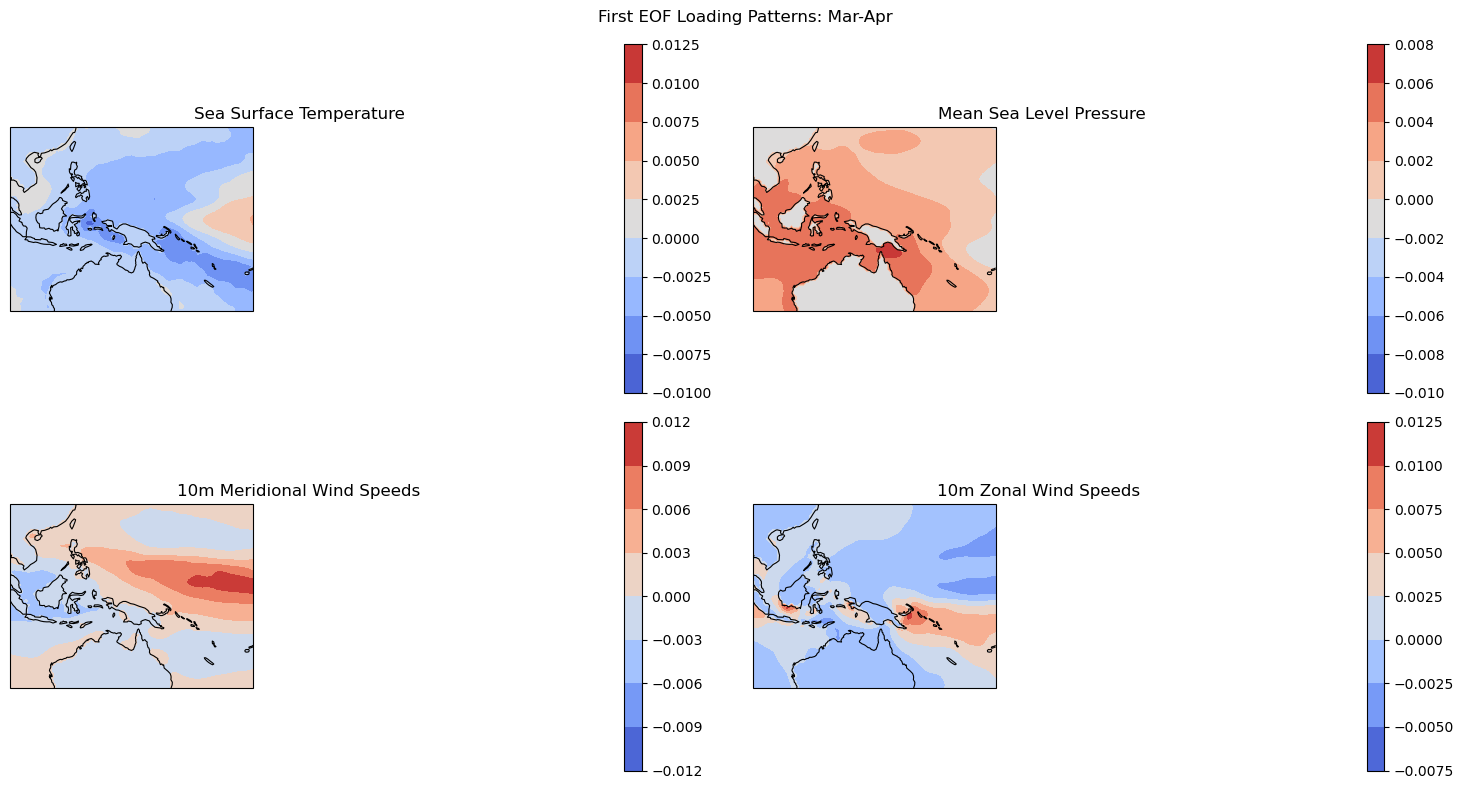

TypeError: 'GeometryCollection' object is not subscriptable

Error in callback <function _draw_all_if_interactive at 0x1262fc2c0> (for post_execute), with arguments args (),kwargs {}:


TypeError: 'GeometryCollection' object is not subscriptable

TypeError: 'GeometryCollection' object is not subscriptable

<Figure size 1500x800 with 6 Axes>

In [196]:
for i, eof in enumerate(eofs):
    plot_loadingPatterns(eof[0], bi_monthly_labels[i])

# JJ_comb

### NEXT TIME
- figure out why the contour plots wont work past April
- fix size of contour plots
- discuss which plots we need to keep